In [4]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense
import keras.backend as K
from keras.datasets import mnist
import keras.layers as layers 
import matplotlib.pyplot as plt
import numpy as np
from keras import losses
from keras.models import Model

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32')
x_train = x_train/255.0

x_test = x_test.astype('float32')
x_test = x_test/255.0

In [6]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0237 - val_loss: 0.0090
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.004

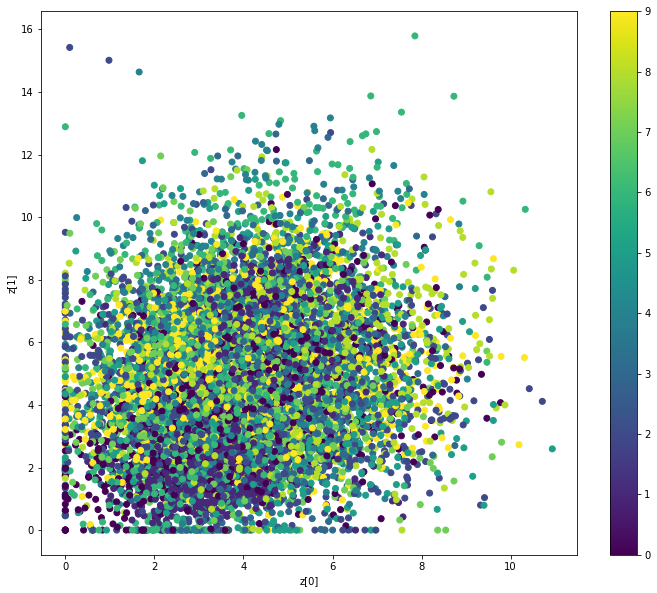

In [8]:
def plot_label_clusters(autoencoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    encoded_data = autoencoder.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


_, (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_label_clusters(autoencoder, x_test, y_test)

In [9]:
# VAE 

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim, ))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)


def sampling(args):

  z_mean, z_log_sigma = args

  epsilon = K.random_normal(shape= (K.shape(z_mean)[0], latent_dim), 
                            mean=0, stddev=0.1)
  
  return z_mean + K.exp(z_log_sigma) * epsilon

z = keras.layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(latent_dim, ), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# Decoder
decoder = keras.Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae')

# MSE 
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

# KL Loss
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# Total Loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [10]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train, batch_size=256, epochs=10, verbose=1,
        validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 2s 5ms/step - loss: 251.9243 - val_loss: 196.4354
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 189.5684 - val_loss: 184.4785
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 181.7475 - val_loss: 177.4293
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 174.1894 - val_loss: 170.3942
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 169.2864 - val_loss: 167.3647
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 167.0562 - val_loss: 165.6924
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 165.6489 - val_loss: 164.5001
Epoch 8/10
235/235 [==============================] - 1s 4ms/step - loss: 164.5424 - val_loss: 163.5671
Epoch 9/10
235/235 [==============================] - 1s 5ms/step - loss: 163.6658 - val_loss: 163.0355
Epoch 10/10
235/235 [==============================] - 1s 5ms/st

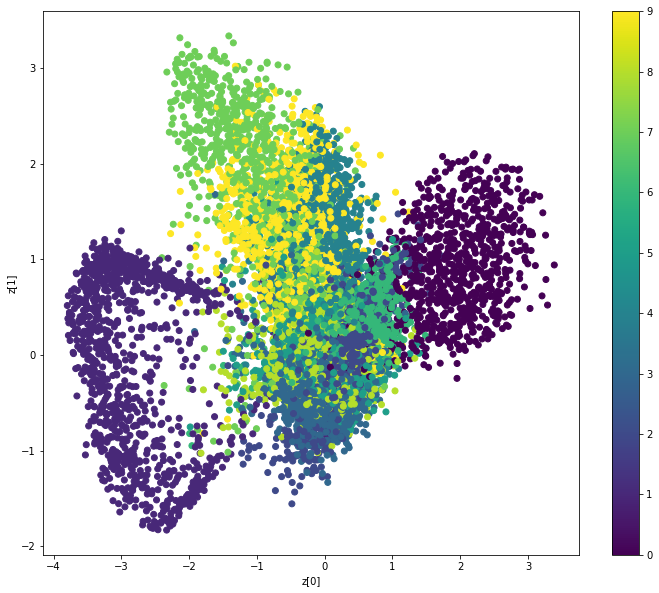

In [11]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


_, (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.

plot_label_clusters(vae, x_test, y_test)